## Covid-19 : severity of illness detection

Use case: Predicting the severity of illness of a covid-19 infected person.

The Model focuses on predicting the severity of ilness of a corona patient. This would individuals to have an idea about the risk they may face in the future. This can potentially avoid unwanted panic at the same time preparing them to tackle difficult situation.

Data sets : https://www.kaggle.com/shirmani/characteristics-corona-patients

In [ ]:
!pip install pyspark

In [2]:
from pyspark.sql import SparkSession
spark = SparkSession.builder.getOrCreate()

In [ ]:
# ## loading data sets from object store
# # import ibmos2spark
# # # # @hidden_cell
# # credentials = {
# #     'endpoint': 'https://s3-api.us-geo.objectstorage.service.networklayer.com',
# #     'service_id': 'iam-ServiceId-63784756-c48c-492e-8639-922f85084a09',
# #     'iam_service_endpoint': 'https://iam.cloud.ibm.com/oidc/token',
# #     'api_key': '-tIBBUc6SMTuni6bUKoo3GtAae1CkvFyI36Fm7tCPoM5'
# # }

# configuration_name = 'os_49a160d1843e4e2fa65d9255c099b6bc_configs'
# cos = ibmos2spark.CloudObjectStorage(sc, credentials, configuration_name, 'bluemix_cos')
# from pyspark.sql import SparkSession
# spark = SparkSession.builder.getOrCreate()
# df = spark.read\
#   .format('org.apache.spark.sql.execution.datasources.csv.CSVFileFormat')\
#   .option('header', 'true')\
#   .load(cos.url('Characteristics_Corona_patients_version_5 13-6-20.csv', 'ibmdatascience-donotdelete-pr-fzplx6yxnis5sm'))
# df.show()

In [ ]:
!git clone https://github.com/govindvarmatn/IBMCapstone.git -b data

In [3]:
df = spark.read.options(header = 'true').csv('IBMCapstone/')


In [7]:
df.printSchema

<bound method DataFrame.printSchema of DataFrame[age: string, age_band: string, background_diseases: string, background_diseases_binary: string, city: string, confirmed_date: string, country: string, date_onset_symptoms: string, deceased_date: string, infected_by: string, infection_place: string, region: string, released_date: string, return_date: string, severity_illness: string, sex: string, smoking: string, symptoms: string, treatment: string, id: string, return_date_until_date_onset_symptoms: string, date_onset_symptoms_until_confirmed_date: string, confirmed_date_until_released_date: string, confirmed_date_until_deceased_date: string, severity_illness_infectious_person: string, ind: string]>

In [8]:
df.count()

1017193

In [9]:
# importing the spark data frame to pandas for doing EDA and visualiztion
pdf = df.toPandas()
print('description :')
print(pdf.describe())
print('info :')
print(pdf.info())

description :
           age age_band  ... severity_illness_infectious_person      ind
count   460724   462766  ...                                204  1016701
unique     284       71  ...                                  4  1016701
top       30.0     30.0  ...                               good   947140
freq     11719   110476  ...                                163        1

[4 rows x 26 columns]
info :
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1017193 entries, 0 to 1017192
Data columns (total 26 columns):
 #   Column                                    Non-Null Count    Dtype 
---  ------                                    --------------    ----- 
 0   age                                       460724 non-null   object
 1   age_band                                  462766 non-null   object
 2   background_diseases                       144711 non-null   object
 3   background_diseases_binary                620663 non-null   object
 4   city                                     

In [10]:
## cleaning pandas df to explore data and visualize it 

In [11]:
def filter_num(val):
    try:
        val = int(float(str(val)))
        return True
    except:
        return False

In [12]:
pdf.columns
pdf = pdf[(pdf['age'].apply(lambda x: filter_num(x)))]
pdf = pdf[(pdf['age_band'].apply(lambda x: filter_num(x)))]
pdf[['age','age_band']] = pdf[['age','age_band']].astype(float)

In [13]:
pdf[['smoking','background_diseases_binary']] = pdf[['smoking','background_diseases_binary']].fillna(0).astype(float)

In [ ]:
pdf['sex'] = pdf['sex'].fillna('others').str.replace('others','0').replace('male','1').replace('female','2').astype(float)

In [ ]:
pdf['treatment'] = pdf['treatment'].fillna('home isolation')

In [ ]:
def fillone(x):
    if x not in ['0',0]:
        return 1
    else:
        return 0

In [ ]:
pdf['symptoms'] = pdf['symptoms'].fillna(0).apply(lambda x: fillone(x))

In [ ]:
pdf['severity_illness'] = pdf['severity_illness'].fillna('good')

In [ ]:
pdf_explore = pdf [['age','age_band','smoking','background_diseases_binary','sex','treatment','symptoms','severity_illness']]

## finding correlation matix 

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


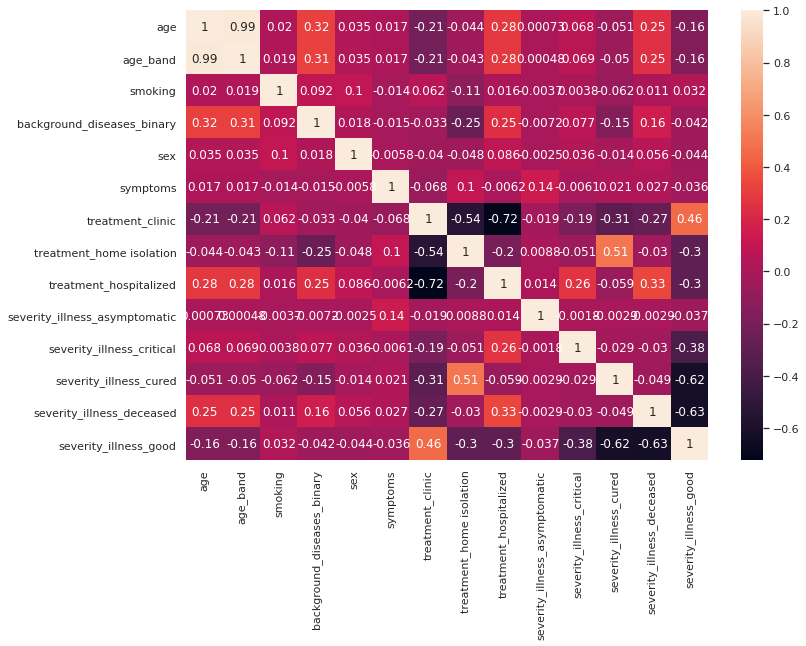

In [ ]:
import seaborn as sns
import pandas as pd
from matplotlib import pyplot
%matplotlib inline

sns.set(rc={'figure.figsize':(11.7,8.27)})
pdf_explore_encoded = pd.get_dummies(pdf_explore, ['treatment','severity_illness'])
sns.heatmap(pdf_explore_encoded.corr(),annot = True)

## Data Vsualiztion and analysis

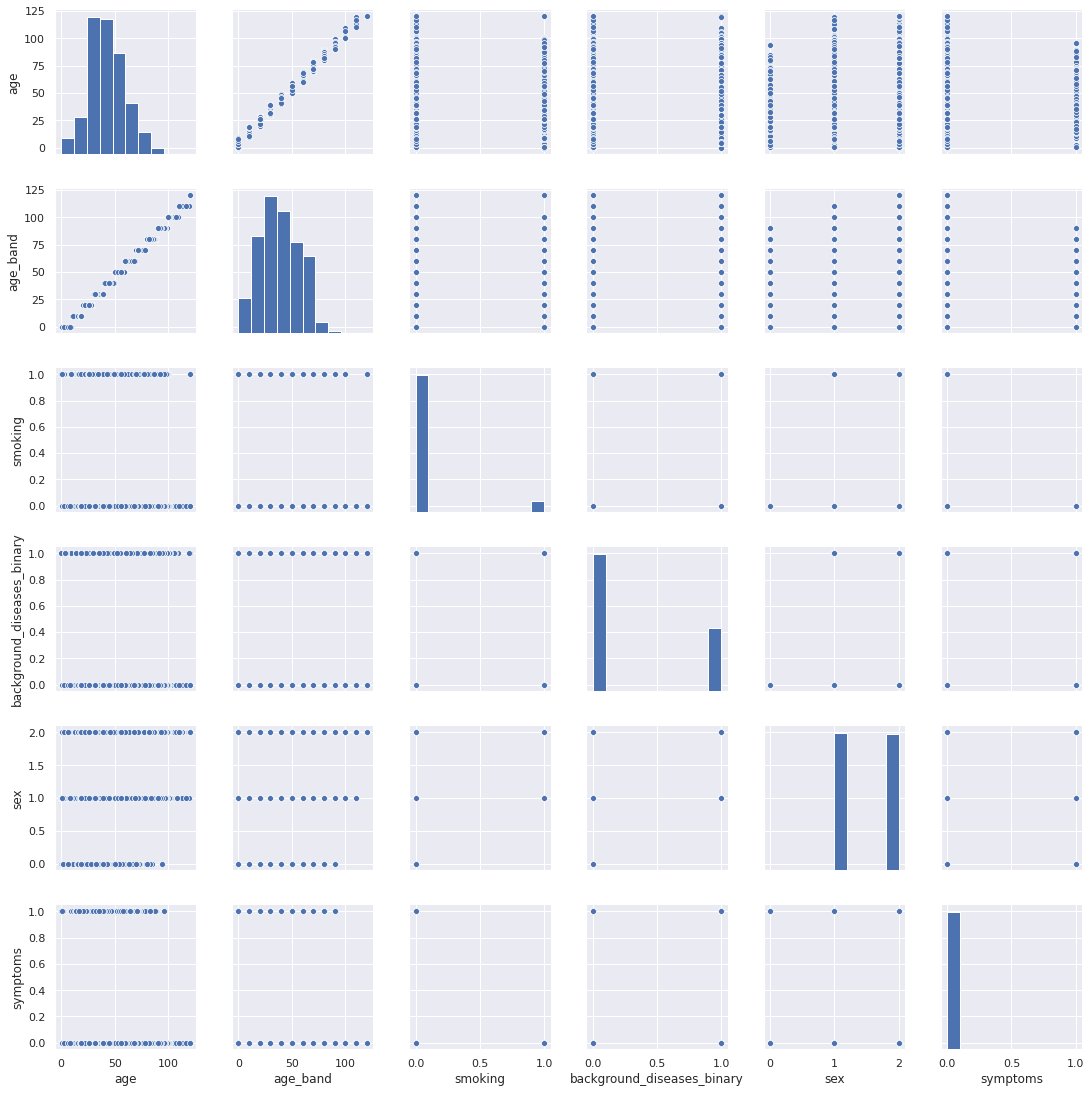

In [ ]:
sns.pairplot(pdf_explore)

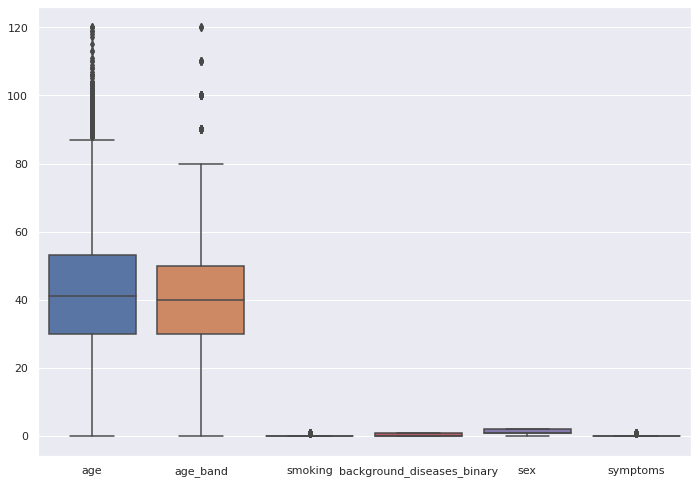

In [ ]:
sns.boxplot(data=pdf_explore)

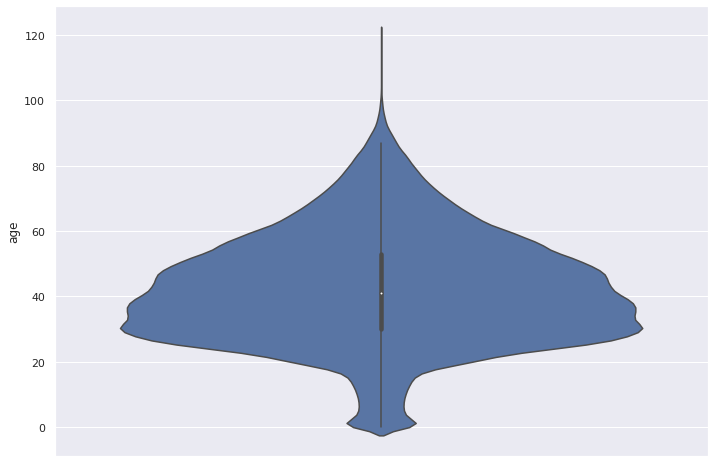

In [ ]:
sns.violinplot(y =pdf_explore['age'])

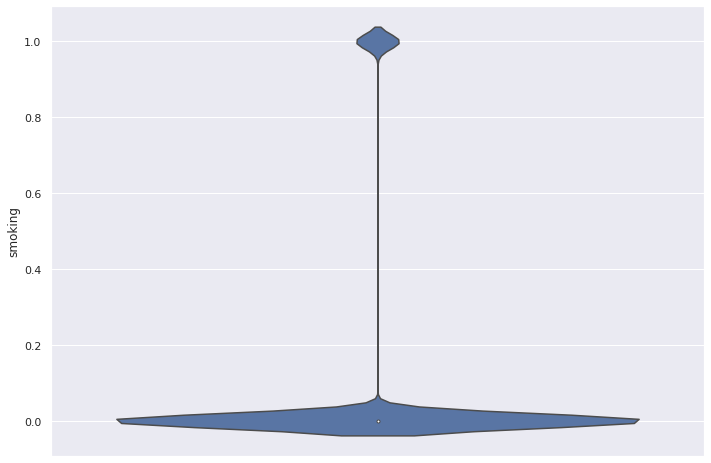

In [ ]:
sns.violinplot(y =pdf_explore['smoking'])

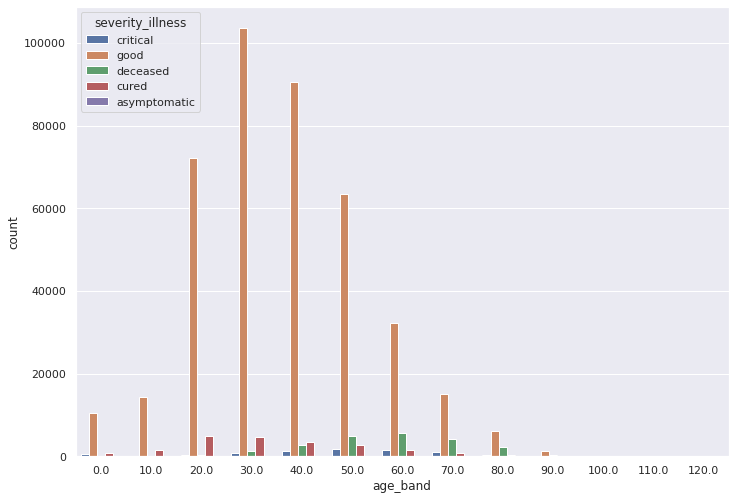

In [ ]:
sns.countplot(x='age_band', data=pdf_explore, hue='severity_illness')

## Understanding from graphs

It can be understood that very less people fall into critical and deseased catagory.
But the age band readings for people who are critical and deseased can be missleading because the sample contains most of the people infected in that range.

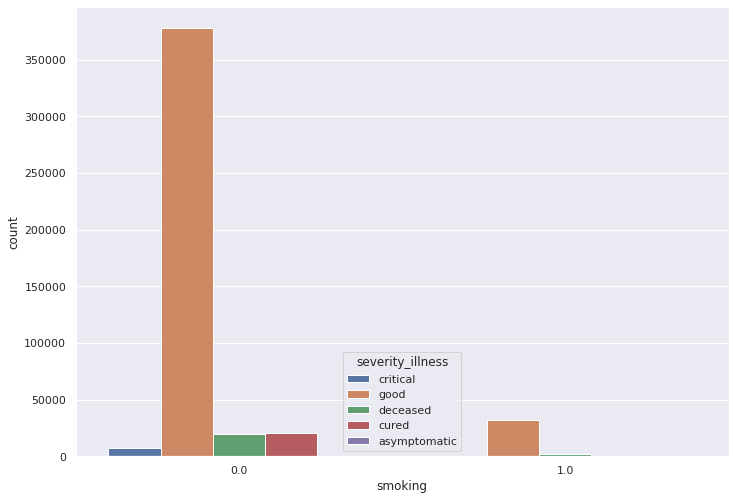

In [ ]:
sns.countplot(x='smoking', data=pdf_explore, hue='severity_illness')

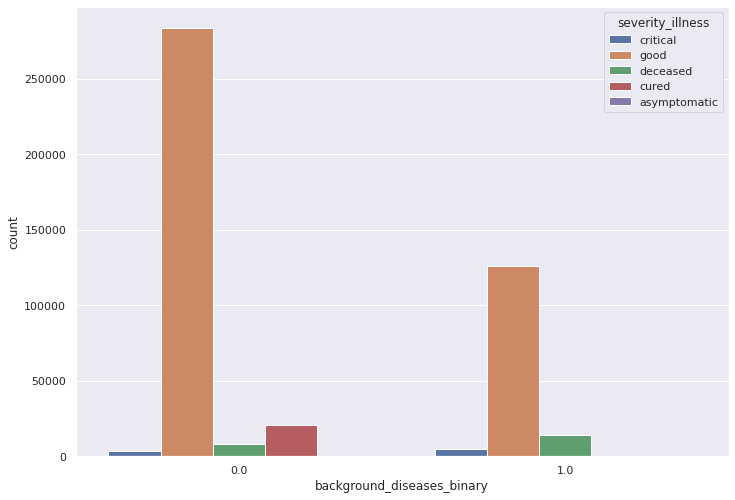

In [ ]:
sns.countplot(x='background_diseases_binary', data=pdf_explore, hue='severity_illness')

## Understanding from graphs

It was found that people having some background desease tend to have severe conditions.
The graphs related to smoking is not so rlevent because the dataset doues not have enough evidence

## Pyspark

## Feature engineering and cleaning of data

In [4]:
df = df.select(['age','age_band','background_diseases','background_diseases_binary','sex','smoking','symptoms','treatment','severity_illness','confirmed_date_until_released_date','confirmed_date_until_deceased_date'])

In [5]:
import pandas as pd
from pyspark.sql.functions import pandas_udf
from pyspark.sql.functions import PandasUDFType
from pyspark.sql.types import StructType, StructField

In [ ]:
!java -version

In [ ]:
!sudo apt install openjdk-8-jdk


In [ ]:
# Enter 2
!sudo update-alternatives --config java

## Feature engineering

In [6]:
schema = '''
age string,
age_band string,
background_diseases string,
background_diseases_binary string,
sex string,
smoking string,
symptoms string,
treatment string,
severity_illness string,
confirmed_date_until_released_date string,
confirmed_date_until_deceased_date string ,
Symptom_fever int,
symptom_cough int,
symptom_pneumonia int,
symptom_breathing_difficulty int,
no_symptop int,
symptom_others int
'''

In [ ]:
!pip install pyarrow==0.15.1

In [7]:
## creating a one hot encoded matrix (features) by spliting column(symptoms) containging a list of values
## using pandas udfs for more symplicity

from pyspark.sql.types import StringType,DoubleType,FloatType,IntegerType

def create_symptoms_features(pdf):
    symptoms = [i.strip() for i in str(pdf['symptoms'][0]).split(',')]
    pdf['Symptom_fever'], pdf['symptom_cough'],pdf['symptom_pneumonia'],pdf['symptom_breathing_difficulty'],pdf['no_symptop'],pdf['symptom_others'] = 0,0,0,0,0,0
    if 'fever' in symptoms:
        pdf['Symptom_fever'] = 1
    if 'cough' in symptoms:
        pdf['symptom_cough'] = 1
    if 'pneumonia' in symptoms:
        pdf['symptom_pneumonia'] = 1
    if 'breathing difficulty' in symptoms:
        pdf['symptom_breathing_difficulty'] = 1
    if any(map(lambda each: each in symptoms, ['null','','no_symptom'])):
        pdf['no_symptop'] = 1
    else:
        pdf['symptom_others'] = 1
    return pdf
                    
df_symptom_features = df.groupby('symptoms').applyInPandas(create_symptoms_features,schema=schema)
    


In [8]:
## creating a one hot encoded matrix (features) by spliting column(symptoms) containging a list of values
## using pandas udfs for more symplicity

schema = StructType(list(df_symptom_features.schema) + [StructField('disease_diabetes',IntegerType(),True),StructField('disease_cancer',IntegerType(),True),StructField('disease_heart',IntegerType(),True),StructField('disease_asthma',IntegerType(),True),StructField('disease_others',IntegerType(),True),StructField('no_disease',IntegerType(),True)])
@pandas_udf(schema, PandasUDFType.GROUPED_MAP)
def create_disease_features(pdf):
    symptoms = [i.strip() for i in str(pdf['symptoms'][0]).split(',')]
    pdf['disease_diabetes'], pdf['disease_cancer'],pdf['disease_heart'],pdf['disease_asthma'],pdf['no_disease'],pdf['disease_others'] = 0,0,0,0,0,0
    if 'diabetes' in symptoms:
        pdf['disease_diabetes'] = 1
    if 'coronary heart disease' in symptoms:
        pdf['disease_heart'] = 1
    if 'cancer' in symptoms:
        pdf['disease_cancer'] = 1
    if 'asthma' in symptoms:
        pdf['disease_asthma'] = 1
    if any(map(lambda each: each in symptoms, ['null',''])):
        pdf['no_disease'] = 1
    else:
        pdf['disease_others'] = 1
    return pdf
                    
df_disease_features = df_symptom_features.groupby('background_diseases').apply(create_disease_features)

/usr/local/lib/python3.6/dist-packages/pyspark/sql/pandas/group_ops.py:76: UserWarning: It is preferred to use 'applyInPandas' over this API. This API will be deprecated in the future releases. See SPARK-28264 for more details.
  "more details.", UserWarning)


In [10]:
## dropping unwanted features
df_disease_features = df_disease_features.drop('age','background_diseases','background_diseases_binary','symptoms')


## Cleansing Data

In [11]:
## block to populate missing value in age_band with the average
import pyspark
from pyspark.sql import SQLContext
from pyspark.sql.types import *
from pyspark.sql import SQLContext
from pyspark.sql.functions import udf

def age_band_fill(val):
    try:
        return int(float(str(val)))
    except:
        return 40
 
    

age_band_fill = udf(age_band_fill, IntegerType())

df_featured_age = df_disease_features.withColumn('age_band',age_band_fill(df_disease_features['age_band']))

In [12]:
## block to populate missing value in sex with the 'others'
def sex_col_fill(val):
    if str(val).strip() not in ('male','female'):
        return 'others'
    else:
        return str(val).strip()
 
    

sex_col_fill = udf(sex_col_fill, StringType())

df_featured_sex = df_featured_age.withColumn('sex',sex_col_fill(df_featured_age['sex']))

In [13]:
## filling missing values in smoking with value = 0
def smoking_col_fill(val):
    try:
        if int(float(val)) not in (0,1):
            return 0
        else:
            return int(float(val))
    except:
        return 0
 
    

smoking_col_fill = udf(smoking_col_fill, IntegerType())

df_featured_smoking = df_featured_sex.withColumn('smoking',smoking_col_fill(df_featured_sex['smoking']))

In [14]:
## filling the missing treatment column with the value 'home isolation'
def treatment_col_fill(val):
    if val not in ('hospitalized','clinic','home isolation'):
        return 'home isolation'
    else:
        return val
    

treatment_col_fill = udf(treatment_col_fill, StringType())

df_featured = df_featured_smoking.withColumn('treatment',treatment_col_fill(df_featured_smoking['treatment']))

In [15]:
## filling missing values in column 'hosp_days' using the data 
## hosp_days is a column that contains the number of days the patient was admitted before recovery or deadth
## the missing values are populated with some external study based on Indian Patient study
import re
def hospitalised_days(hosp,die,treatment):
    try:
        hosp = re.findall(r'\b\d+\b', hosp)[0]
        return int(float(hosp))
    except:
        try:
            die = re.findall(r'\b\d+\b', die)[0]
            return int(float(die))
        except:
            if treatment == 'hospitalized':
                return 25
            else:
                return 17
    

hospitalised_days = udf(hospitalised_days, IntegerType())


df_featured_final = df_featured.withColumn('hosp_days',hospitalised_days(df_featured['confirmed_date_until_released_date'],df_featured['confirmed_date_until_deceased_date'],df_featured['treatment']))

In [16]:
## removing unwanted columns
df_featured_final = df_featured_final.drop('confirmed_date_until_released_date','confirmed_date_until_deceased_date','age')

In [17]:
## creating the target variable
## Missing values are dealt with the present scenario scene in India
## the target contains 5 values namely ['asymptomatic','good','bad','critical','deseased']
def target_feature(illness,treatment,hosp):
    illness = str(illness)
    if illness == 'cured':
        if treatment == 'hospitalized' and hosp > 45:
            return 'critical'
        elif treatment == 'hospitalized' and hosp > 30:
            return 'bad'
        else:
            return 'good'
    elif illness in ('null','0.0','None'):
        return 'asymptomatic'
    elif illness in ('2.0'):
        return 'bad'
    else:
        return illness
    
target_feature = udf(target_feature, StringType())

df_final = df_featured_final.withColumn('severity_illness',target_feature(df_featured_final['severity_illness'],df_featured_final['treatment'],df_featured_final['hosp_days']))
df_final = df_final.fillna({'severity_illness':'asymptomatic'})

In [18]:
## chaniging data types and persisting the final dataframe

df_final = df_final.withColumn('age_band',df_final['age_band'].cast('int') )
df_final = df_final.withColumn('hosp_days',df_final['hosp_days'].cast('int') )
df_final = df_final.fillna(0)
df_final = df_final.persist()

In [19]:
df_final.describe

<bound method DataFrame.describe of DataFrame[age_band: int, sex: string, smoking: int, treatment: string, severity_illness: string, Symptom_fever: int, symptom_cough: int, symptom_pneumonia: int, symptom_breathing_difficulty: int, no_symptop: int, symptom_others: int, disease_diabetes: int, disease_cancer: int, disease_heart: int, disease_asthma: int, disease_others: int, no_disease: int, hosp_days: int]>

In [23]:
## splitting the data into training and test set
splits = df_final.randomSplit([0.8,0.2])
df_test = splits[1]
df_train = splits[0]

## Machine learning

The idea here is to use a MultilayerPerceptronClassifier clasifier to predict the severity of ilness with the help of all the other features.
The model is trained and fit with MultilayerPerceptronClassifier
MultilayerPerceptronClassifier is similar to deeplearnign  where we give the number of layers and number of nods in each layer as layers = [17, 30,20,8, 5]
The model is evaluated with the performance measure accuracy
The aim is to clasify illness severity among the below mentioned classes


1. asymptomatic
2. good
3. bad
4. critical
5. deseased

With the help of this clasifier patients could re-asses their condition eventually reducing panic at the same time proper precautions can also be taken

In [ ]:
from pyspark.ml.feature import VectorAssembler, OneHotEncoder,StringIndexer,Normalizer
from pyspark.ml import Pipeline
from pyspark.ml.classification import LogisticRegression,OneVsRest,RandomForestClassifier
from pyspark.mllib.classification import LogisticRegressionWithLBFGS
from pyspark.ml.classification import MultilayerPerceptronClassifier

## number of input features = 17
## output classes = 5

layers = [17 ,8, 5]

In [ ]:
## creating a pipeline

stringindexer_sex = StringIndexer(inputCol = 'sex', outputCol = 'sex_index')
#encoder_sex = OneHotEncoder(inputCol = 'sex_index', outputCol = 'sex_encoder')
stringindexer_treatment = StringIndexer(inputCol = 'treatment', outputCol = 'treatment_index')
#encoder_treatment = OneHotEncoder(inputCol = 'treatment_index', outputCol = 'treatment_encoder')
vectorassembler = VectorAssembler(inputCols = ['age_band','sex_index','smoking','treatment_index','Symptom_fever','symptom_cough','symptom_pneumonia', \
                                  'symptom_breathing_difficulty', 'symptom_others','no_symptop','disease_diabetes','disease_cancer','disease_heart', \
                                  'disease_asthma', 'disease_others','no_disease','hosp_days'], outputCol = 'feature_dum' )
normalizer = Normalizer(inputCol = 'feature_dum',outputCol = 'features',p=1.0)
stringindexer_label = StringIndexer(inputCol = 'severity_illness', outputCol = 'label')
#lsvc = LinearSVC(maxIter = 10)
#cls = RandomForestClassifier(numTrees=10)
cls = MultilayerPerceptronClassifier(maxIter= 200, layers=layers, blockSize=128, seed = 4, solver='l-bfgs')
#ovr = OneVsRest(classifier=cls)
#pipeline = Pipeline(stages = [stringindexer_sex,encoder_sex,stringindexer_treatment,encoder_treatment,vectorassembler,normalizer,stringindexer_label,cls])
pipeline = Pipeline(stages = [stringindexer_sex,stringindexer_treatment,vectorassembler,normalizer,stringindexer_label,cls])

In [ ]:
## fittimg the data
model = pipeline.fit(df_train)

## Evalyating model performace 

the model performace is evaluated with accuracy measure.

In [ ]:
## predicting values
prediction = model.transform(df_train)

In [ ]:
predictionAndLabels_train = prediction.select("label","prediction")

In [ ]:
## evaluating training set accuracy

from pyspark.ml.evaluation import MulticlassClassificationEvaluator

evaluator = MulticlassClassificationEvaluator(metricName="accuracy")
print("train set accuracy = " + str(evaluator.evaluate(predictionAndLabels_train)))

train set accuracy = 0.9604314116211843


In [ ]:
prediction_test = model.transform(df_test)

In [ ]:
## evaluating test set accuracy

eval = MulticlassClassificationEvaluator().setMetricName('accuracy').setLabelCol('label').setPredictionCol('prediction')
print("test set accuracy =", eval.evaluate(prediction_test))

test set accuracy = 0.9606523172616059


## Deeplearning

Using Keras with tensorflow backend to create a sequential model
The model would be supervised learning model.
The aim of the model is to predict the severity of illness of covid patients using the patient data.

The model is evaluated with the performance measure accuracy The aim is to clasify illness severity among the below mentioned classes

1. asymptomatic
2. good
3. bad
4. critical
5. deseased



In [20]:
from keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Dropout

Using TensorFlow backend.


In [191]:
## defining batch size classes and epochs
batch_size = 128
num_classs = 5
epochs = 20

In [125]:
## creating training and test set
pdf_train = df_train.toPandas()
pdf_test  = df_test.toPandas()

In [130]:
##creating features and label
y_train = pdf_train['severity_illness']
x_train = pdf_train.drop(['severity_illness'],axis  =1) 

In [131]:
y_test = pdf_test['severity_illness']
x_test = pdf_test.drop(['severity_illness'],axis  =1) 

In [132]:
## creatibg catagorical values for test and traing set
## both for featuress and label

x_train = pd.get_dummies(x_train).values.astype('float32')
y_train = pd.get_dummies(y_train).values.astype('float32')

x_test = pd.get_dummies(x_test).values.astype('float32')
y_test = pd.get_dummies(y_test).values.astype('float32')

In [119]:
print(x_train.shape)
print(y_train.shape)
print(x_test.shape)
print(y_test.shape)

(813473, 21)
(813473, 5)
(203720, 21)
(203720, 5)


In [120]:
## function for mormalization
## Normalizing each feature with max of it
def normalize(arr):
  arr = arr / arr.max(axis=0)
  return arr


In [121]:
## normalizing training and test set

x_train = normalize(x_train).astype('float32')
x_test = normalize(x_test).astype('float32')

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: RuntimeWarning: invalid value encountered in true_divide
  


In [186]:
## creating a sequential model

model = Sequential()
model.add(Dense(15,activation='tanh',input_shape =(21,)))
model.add(Dropout(0.2))
model.add(Dense(15,activation='tanh',input_shape =(21,)))
model.add(Dropout(0.2))
model.add(Dense(10,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(10,activation='tanh'))
model.add(Dropout(0.2))
model.add(Dense(num_classs,activation = 'softmax'))

model.summary()

Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 15)                330       
_________________________________________________________________
dropout_26 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 15)                240       
_________________________________________________________________
dropout_27 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 10)                160       
_________________________________________________________________
dropout_28 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 10)              

In [200]:
## compiling the model

model.compile(loss = 'categorical_crossentropy',optimizer = 'adam',metrics = ['accuracy'])

In [201]:
## fit the data 

history = model.fit(x_train,y_train ,batch_size = batch_size,epochs = epochs, validation_data = (x_test,y_test))

Train on 813473 samples, validate on 203720 samples
Epoch 1/20
813473/813473 [==============================] - 11s 14us/step - loss: 0.1001 - accuracy: 0.9660 - val_loss: 0.0842 - val_accuracy: 0.9683
Epoch 2/20
813473/813473 [==============================] - 11s 13us/step - loss: 0.1011 - accuracy: 0.9659 - val_loss: 0.0897 - val_accuracy: 0.9680
Epoch 3/20
813473/813473 [==============================] - 11s 13us/step - loss: 0.0999 - accuracy: 0.9660 - val_loss: 0.0843 - val_accuracy: 0.9682
Epoch 4/20
813473/813473 [==============================] - 11s 14us/step - loss: 0.1003 - accuracy: 0.9661 - val_loss: 0.0871 - val_accuracy: 0.9681
Epoch 5/20
813473/813473 [==============================] - 11s 14us/step - loss: 0.0998 - accuracy: 0.9661 - val_loss: 0.0841 - val_accuracy: 0.9687
Epoch 6/20
813473/813473 [==============================] - 11s 13us/step - loss: 0.1002 - accuracy: 0.9659 - val_loss: 0.0852 - val_accuracy: 0.9679
Epoch 7/20
813473/813473 [======================

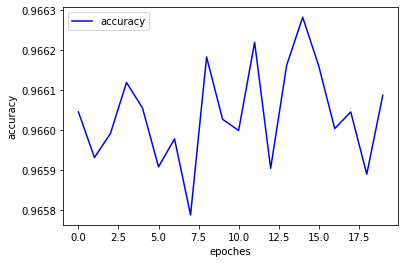

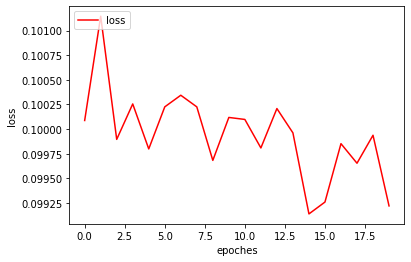

In [202]:
## plotting accuracy and loss versus epoche

from matplotlib import pyplot
pyplot.plot(history.history['accuracy'],"-b", label="accuracy")
pyplot.xlabel('epoches')
pyplot.ylabel('accuracy')
pyplot.legend(loc="upper left")
pyplot.show()

from matplotlib import pyplot
pyplot.plot(history.history['loss'],"-r", label="loss")
pyplot.xlabel('epoches')
pyplot.ylabel('loss')
pyplot.legend(loc="upper left")
pyplot.show()

In [203]:
score = model.evaluate(x_train,y_train,verbose = 0)

print('training set accuracy =',score[1])
print('training set loss =',score[0])

training set accuracy = 0.9695736765861511
training set loss = 0.08530452178694096


In [204]:
score = model.evaluate(x_test,y_test,verbose = 0)

print('test set accuracy =',score[1])
print('test set loss =',score[0])

test set accuracy = 0.9698311686515808
test set loss = 0.08494994742148489


In [205]:
!pip install h5py

In [209]:
## saving the model
model.save("model.h5")
print("Saved model to disk")

Saved model to disk


In [211]:
## loading model

from numpy import loadtxt
from keras.models import load_model
 
# load model
model = load_model('model.h5')
# summarize model.
model.summary()
# load dataset

score = model.evaluate(x_test,y_test,verbose = 0)

print('test set accuracy =',score[1])
print('test set loss =',score[0])


Model: "sequential_13"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_38 (Dense)             (None, 15)                330       
_________________________________________________________________
dropout_26 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_39 (Dense)             (None, 15)                240       
_________________________________________________________________
dropout_27 (Dropout)         (None, 15)                0         
_________________________________________________________________
dense_40 (Dense)             (None, 10)                160       
_________________________________________________________________
dropout_28 (Dropout)         (None, 10)                0         
_________________________________________________________________
dense_41 (Dense)             (None, 10)              